In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install tensorflow_text
import tensorflow_text as text
import tensorflow as tf
import tensorflow_hub as hub

In [4]:
import pandas as pd

df=pd.read_csv('/kaggle/input/sentiment/labeled_youtube_comments.csv')
df['Sentiment'] = df['Sentiment'].replace({'Neutral': 'Positive'})
df['Sentiment'].value_counts()

Sentiment
Positive    5314
Negative    5218
Name: count, dtype: int64

In [5]:
df.columns

Index(['Comment', 'Sentiment'], dtype='object')

In [6]:
df.fillna(' ',inplace=True)

In [8]:
# Map 'positive' to 1 and 'negative' to 0
df['label'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})

print("\nDataset with Numeric Labels:")
print(df)



Dataset with Numeric Labels:
                                                 Comment Sentiment  label
0            Psycho lady isko police ki wardi kisne dedi  Negative      0
1                                  Very good cisf  women  Positive      1
2      Kulwinder kaur need promotion as she support h...  Positive      1
3                                          Real sherni ❤  Positive      1
4      Tu galt A foji di dheya punjabi 20 pisha jhoth...  Positive      1
...                                                  ...       ...    ...
10527                                      Ab naukri gai  Positive      1
10528  Wo apna kaam krte h......jb aap k kmi hogi tb ...  Negative      0
10529  Maza aa geya Dil garden garden ho geya salute ...  Positive      1
10530                                    Very good bravo  Positive      1
10531                                          Sahi kiya  Positive      1

[10532 rows x 3 columns]


In [11]:
from sklearn.model_selection import train_test_split

x=df['Comment']
y=df['label']


X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y)


In [12]:
df.isna().sum()

Comment      0
Sentiment    0
label        0
dtype: int64

In [13]:
df['label'].count()

10532

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(7899,) (2633,) (7899,) (2633,)


In [15]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-l-12-h-768-a-12/versions/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

Attaching model 'tensorflow/bert/tensorflow2/en-uncased-preprocess/3' to your Kaggle notebook...
Attaching model 'tensorflow/bert/tensorflow2/en-uncased-l-12-h-768-a-12/4' to your Kaggle notebook...


In [16]:
fii = tf.keras.layers.Dropout(0.2,name='dropout')(pooled_output)
fii=tf.keras.layers.Dense(64,activation='relu',name='hidden')(fii)
fii=tf.keras.layers.Dense(32,activation='relu',name='hiddenn')(fii)
fii=tf.keras.layers.Dense(8,activation='relu',name='hiddennn')(fii)
fii=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(fii)

In [17]:
model=tf.keras.Model(inputs=[text_input],outputs=[fii])

In [18]:
# Compile the mode
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [19]:
model.fit(X_train, y_train, epochs=2, validation_split=0.1)

Epoch 1/2
223/223 [==============================] - 1881s 8s/step - loss: 0.5668 - accuracy: 0.7000 - val_loss: 0.5137 - val_accuracy: 0.7494
Epoch 2/2
223/223 [==============================] - 1867s 8s/step - loss: 0.5317 - accuracy: 0.7315 - val_loss: 0.5169 - val_accuracy: 0.7481


In [20]:
y_predict=model.predict(X_test)
y_pred=np.where(y_predict>0.5,1,0)

83/83 [==============================] - 625s 8s/step


In [21]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

classification_rep = classification_report(y_test, y_pred)

# Print the classification report
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.69      0.74      1305
           1       0.73      0.83      0.78      1328

    accuracy                           0.76      2633
   macro avg       0.76      0.76      0.76      2633
weighted avg       0.76      0.76      0.76      2633



In [23]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 895  410]
 [ 227 1101]]


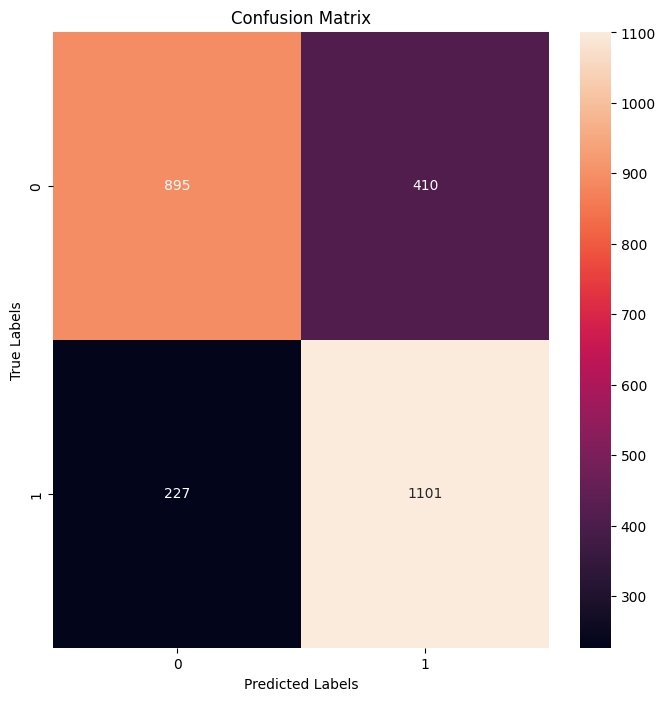

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
name = 'bert_model_2'
saved_model_path = './{}_bert'.format(name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

In [26]:
import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.13.0


In [27]:
model.save('my_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
